# Testing with sklearn models

In [3]:
%cd ..

/Users/izvonkov/nasaharvest/crop-mask


In [174]:
from pathlib import Path
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from tqdm.notebook import tqdm

import pandas as pd

from datasets import datasets

In [7]:
df = pd.concat([d.load_df(to_np=True) for d in datasets if d.name != "EthiopiaTigrayGhent2021"])

/var/folders/1v/87y9n_d5143c_6cp072v3b1c0000gn/T/ipykernel_94788/2516065871.py:1: DtypeWarning: Columns (17) have mixed types.Specify dtype option on import or set low_memory=False.
  df = pd.concat([d.load_df(to_np=True) for d in datasets if d.name != "EthiopiaTigrayGhent2021"])
MalawiCorrectiveLabels2020: 100%|█████████| 4296/4296 [00:03<00:00, 1241.08it/s]


In [12]:
df = df[df["class_probability"] != 0.5].copy() # Remove disagreement points
df["timesteps"] = df["eo_data"].apply(lambda x: x.shape[0])

In [231]:
from src.bboxes import bboxes

def run_baseline(df, bbox, dataset, month="February", padding=2):
    target_bbox = bboxes[bbox]
    
    if month == "February":
        df = df[df["timesteps"] > 13].copy() 
        df["eo_data"] = df["eo_data"].apply(lambda x: x[2:14]) 
    elif month == "September":
        df = df[df["timesteps"] > 20].copy() 
        df["eo_data"] = df["eo_data"].apply(lambda x: x[8:20]) 
    elif month == "November":
        df = df[df["timesteps"] > 22].copy() 
        df["eo_data"] = df["eo_data"].apply(lambda x: x[10:22]) 
    else:
        df = df[df["timesteps"] == 24].copy()
        
    
    test_condition = (df["dataset"] == dataset) & (df["subset"] == "testing")
    val_condition = (df["dataset"] == dataset) & (df["subset"] == "validation")

    df["is_local"] = (
        (df["lat"] >= (target_bbox.min_lat - padding))
        & (df["lat"] <= (target_bbox.max_lat + padding))
        & (df["lon"] >= (target_bbox.min_lon - padding))
        & (df["lon"] <= (target_bbox.max_lon + padding))
    )

    train_condition = ~val_condition & ~test_condition & df["is_local"]

    X_train = df[train_condition]["eo_data"].apply(lambda x: x.flatten()).to_list()
    y_train = (df[train_condition]["class_probability"] > 0.5).to_list()
    X_val = df[val_condition]["eo_data"].apply(lambda x: x.flatten()).to_list()
    y_val = (df[val_condition]["class_probability"] > 0.5).to_list()
    X_test = df[test_condition]["eo_data"].apply(lambda x: x.flatten()).to_list()
    y_test = (df[test_condition]["class_probability"] > 0.5).to_list()

    print(f"Train Crop: {sum(y_train)} ({sum(y_train)/len(y_train):0.2%})")
    print(f"Val Crop: {sum(y_val)} ({sum(y_val)/len(y_val):0.2%})")
    print(f"Test Crop: {sum(y_test)} ({sum(y_test)/len(y_test):0.2%})")

    model = RandomForestClassifier(random_state=0)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    print(f"Val F1: {f1_score(y_val, y_pred):0.2%}")
    print(f"Val Precision: {precision_score(y_val, y_pred):0.2%}")
    print(f"Val Recall: {recall_score(y_val, y_pred):0.2%}")
    print(f"Val Accuracy: {accuracy_score(y_val, y_pred):0.2%}")
    
    cm = confusion_matrix(y_val, y_pred, labels=[0,1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-crop", "Crop"])
    disp.plot()
    
    y_pred = model.predict(X_test)
    print(f"Test F1: {f1_score(y_test, y_pred):0.2%}")
    print(f"Test Precision: {precision_score(y_test, y_pred):0.2%}")
    print(f"Test Recall: {recall_score(y_test, y_pred):0.2%}")
    print(f"Test Accuracy: {accuracy_score(y_test, y_pred):0.2%}")

## Ethiopia_Bure_Jimma_2020

LSTM: F1 Score: 0.8429 (val), 0.8148 (test) [Feb - Feb]

Train Crop: 1448 (37.13%)
Val Crop: 124 (25.67%)
Test Crop: 129 (28.35%)
Val F1: 80.62%
Val Precision: 77.61%
Val Recall: 83.87%
Val Accuracy: 89.65%
Test F1: 84.29%
Test Precision: 83.33%
Test Recall: 85.27%
Test Accuracy: 90.99%


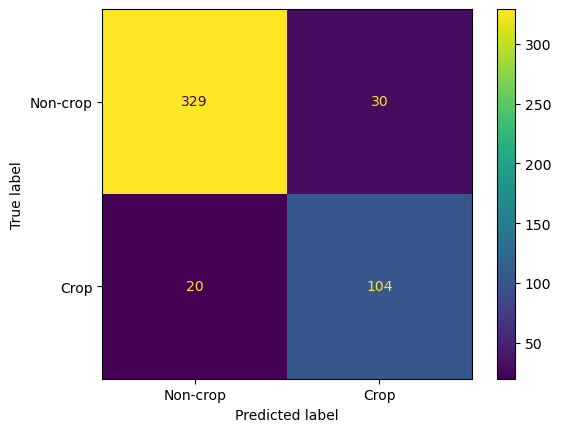

In [232]:
run_baseline(df, "Ethiopia_Bure_Jimma", "Ethiopia_Bure_Jimma_2020")

## Ethiopia_Tigray_2020
LSTM: F1 Score 0.6667 (val), 0.6104 (test) [Feb - Feb]

Train Crop: 2662 (46.58%)
Val Crop: 152 (29.23%)
Test Crop: 139 (27.42%)
Val F1: 69.05%
Val Precision: 63.04%
Val Recall: 76.32%
Val Accuracy: 80.00%
Test F1: 68.20%
Test Precision: 62.65%
Test Recall: 74.82%
Test Accuracy: 80.87%


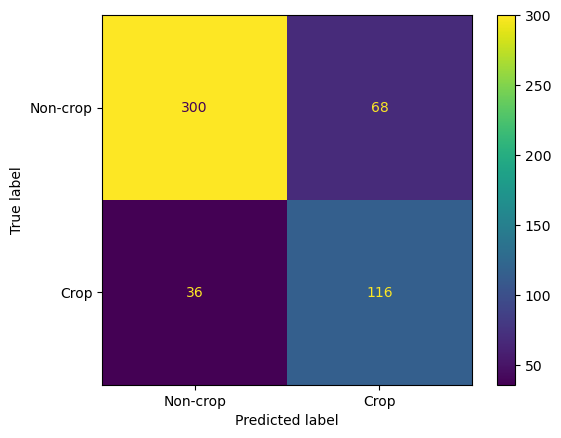

In [233]:
run_baseline(df, "Ethiopia_Tigray", "Ethiopia_Tigray_2020")

## Ethiopia_Tigray_2021

LSTM: F1 Score: 0.733 (val), 0.731 (test) [Feb - Feb]

Train Crop: 2735 (45.40%)
Val Crop: 109 (30.79%)
Test Crop: 109 (29.95%)
Val F1: 54.65%
Val Precision: 74.60%
Val Recall: 43.12%
Val Accuracy: 77.97%
Test F1: 59.60%
Test Precision: 66.29%
Test Recall: 54.13%
Test Accuracy: 78.02%


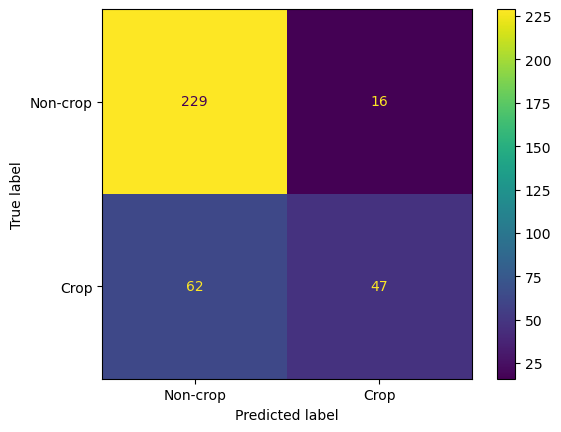

In [234]:
run_baseline(df, "Ethiopia_Tigray", "Ethiopia_Tigray_2021")

## Hawaii_2020
LSTM: F1: 0.421 (val), 0.235 (test) [Feb - Feb]

Train Crop: 5005 (84.15%)
Val Crop: 8 (2.61%)
Test Crop: 6 (1.67%)
Val F1: 11.94%
Val Precision: 6.35%
Val Recall: 100.00%
Val Accuracy: 61.44%
Test F1: 6.45%
Test Precision: 3.36%
Test Recall: 83.33%
Test Accuracy: 59.72%


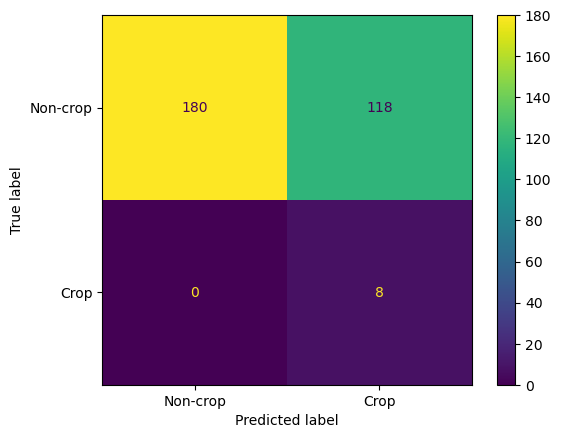

In [235]:
run_baseline(df, "Hawaii", "Hawaii_CEO_2020")

## Namibia_North_2020
LSTM: F1: 0.125 (val), 0.123 (test)

Train Crop: 444 (25.26%)
Val Crop: 7 (1.65%)
Test Crop: 5 (1.13%)
Val F1: 20.69%
Val Precision: 13.64%
Val Recall: 42.86%
Val Accuracy: 94.59%
Test F1: 0.00%
Test Precision: 0.00%
Test Recall: 0.00%
Test Accuracy: 95.05%


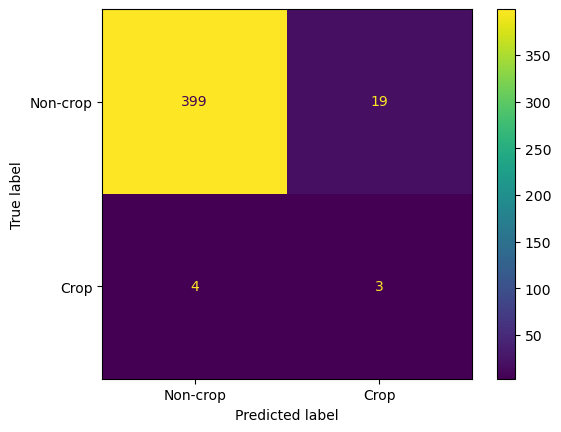

In [236]:
run_baseline(df, "Namibia_North", "Namibia_CEO_2020", month="September")

## Rwanda_2019
LSTM F1: 0.654 (val), 0.630 (test)

Train Crop: 1780 (21.85%)
Val Crop: 172 (33.08%)
Test Crop: 191 (34.41%)
Val F1: 53.74%
Val Precision: 64.75%
Val Recall: 45.93%
Val Accuracy: 73.85%
Test F1: 44.87%
Test Precision: 57.85%
Test Recall: 36.65%
Test Accuracy: 69.01%


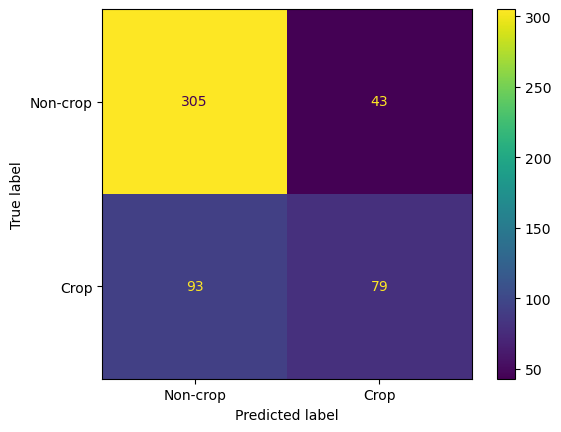

In [237]:
run_baseline(df, "Rwanda", "Rwanda", month="February", padding=3)

## Sudan_Blue_Nile_2019
LSTM: F1: 0.9201 (val), 0.9213 (test) 

Train Crop: 3453 (45.09%)
Val Crop: 174 (34.39%)
Test Crop: 173 (32.89%)
Val F1: 92.05%
Val Precision: 91.01%
Val Recall: 93.10%
Val Accuracy: 94.47%
Test F1: 91.43%
Test Precision: 90.40%
Test Recall: 92.49%
Test Accuracy: 94.30%


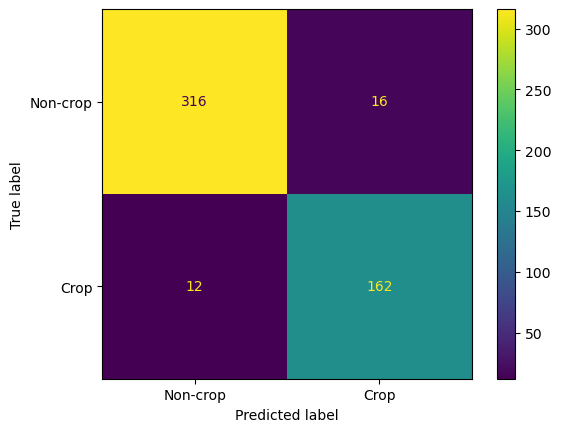

In [238]:
run_baseline(df, "Sudan_Blue_Nile", "Sudan_Blue_Nile_CEO_2019", month="February", padding=3)

## Tanzania_2019

LSTM F1: 0.7249 (val), 0.7354 (test)

Train Crop: 10880 (34.03%)
Val Crop: 630 (30.82%)
Test Crop: 626 (30.73%)
Val F1: 51.15%
Val Precision: 92.15%
Val Recall: 35.40%
Val Accuracy: 79.16%
Test F1: 52.61%
Test Precision: 90.62%
Test Recall: 37.06%
Test Accuracy: 79.48%


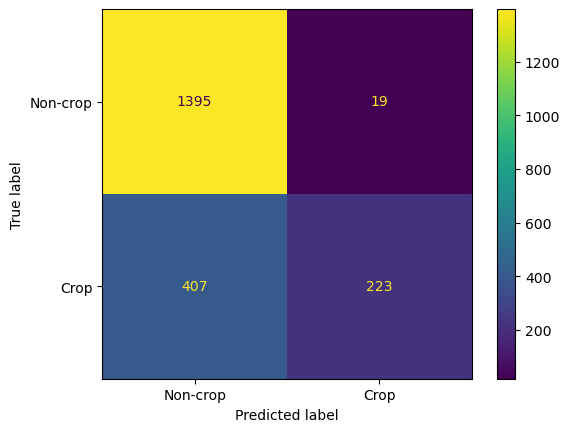

In [239]:
run_baseline(df, "Tanzania", "Tanzania_CEO_2019", month="September", padding=2)

## Zambia_2019
LSTM: F1: 0.5283 (val)

Train Crop: 13015 (33.12%)
Val Crop: 38 (3.56%)
Test Crop: 39 (3.76%)
Val F1: 17.39%
Val Precision: 50.00%
Val Recall: 10.53%
Val Accuracy: 96.44%
Test F1: 8.70%
Test Precision: 28.57%
Test Recall: 5.13%
Test Accuracy: 95.95%


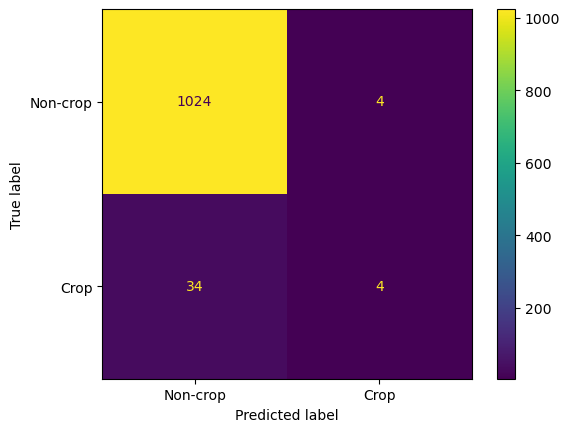

In [240]:
run_baseline(df, "Zambia", "Zambia_CEO_2019", month="November", padding=10)